In [ ]:
import pandas as pd
import numpy as np

In [ ]:
merged_df = pd.read_csv("input_data_sample/merged_data_sample.csv", sep=",")
merged_df['date'] = pd.to_datetime(merged_df['date'], format="%Y-%m-%d %H:%M:%S")

In [ ]:
print(merged_df)

                          rfid  antenna                date  year
0      R 0000 0000000072520688        1 2000-11-24 06:04:52  2000
1      R 0000 0000000072520688        1 2000-11-24 06:04:52  2001
2      R 0000 0000000072520688        1 2000-11-24 06:27:42  2000
3      R 0000 0000000072520688        1 2000-11-24 06:27:42  2001
4      R 0000 0000000072520688        0 2000-11-24 06:32:46  2000
...                        ...      ...                 ...   ...
22610  R 0000 0000000072520790        1 2022-01-24 03:25:49  2021
22611  R 0000 0000000072520790        0 2022-01-24 03:26:04  2022
22612  R 0000 0000000072520790        0 2022-01-24 03:26:04  2021
22613  R 0000 0000000072520790        1 2022-02-11 17:10:23  2022
22614  R 0000 0000000072520790        1 2022-02-11 17:10:28  2022

[22615 rows x 4 columns]


In [ ]:
import datetime
from datetime import timedelta

out = []
out2 = pd.DataFrame()
out3 = []
for start_year in range(1998, 2022):
    print(start_year)
    start_date = datetime.datetime(year=start_year-1, month=9, day=30)
    end_date = start_date + timedelta(days=487)
    dRange = pd.date_range(start=start_date, end=end_date, freq="12H")
    # perform the grid search on time/rfid values
    values = merged_df[merged_df["year"] == start_year].groupby([pd.Grouper(key="date", freq="12H"), "rfid"])["antenna"].last().unstack().reindex(dRange).fillna(method="ffill").fillna(False).astype(int).values
    values_detect_number = merged_df[merged_df["year"] == start_year].groupby([pd.Grouper(key="date", freq="12H"), "rfid"])["antenna"].size().unstack().reindex(dRange).fillna(value=0).astype(int).values
    rfid_year = merged_df[merged_df["year"] == start_year][["rfid","year"]]
    # look for the corresponding breeding labels for this season
    out.extend(values.T)
    out3.extend(values_detect_number.T)
    if not rfid_year.empty:
        out2 = pd.concat([out2, pd.DataFrame(rfid_year.drop_duplicates())])
        
final_value = [[0] for x in range(len(out))]
val = [[0,0] for x in range(975)]
for i in range(len(out)):
    for j in range(975):
        val[j] = [out[i][j],out3[i][j]]
    final_value[i]= np.array(val)

1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021


In [ ]:
from tensorflow import keras
model_NB_B = keras.models.load_model("models/model_determination_B_NB")
model_S_F = keras.models.load_model('models/model_determination_S_F')
model_M_F = keras.models.load_model('models/model_determination_M_F')
model_date_males = keras.models.load_model('models/determination_date_M')
model_date_females = keras.models.load_model('models/determination_date_F')

In [ ]:
prediction_NB_B = np.argmax(model_NB_B.predict(np.array(final_value)), axis=-1)
prediction_S_F = np.argmax(model_S_F.predict(np.array(final_value)), axis=-1)

In [ ]:
values = final_value
rfid_year_list = out2
data = pd.DataFrame({'rfid': rfid_year_list["rfid"], 'year': rfid_year_list["year"], 'pred_NB_B': prediction_NB_B, 'pred_S_F': prediction_S_F})
data.reset_index(inplace=True, drop=True)

data['pred_NB_B'] = data['pred_NB_B'].replace(0, "NB")
data['pred_NB_B'] = data['pred_NB_B'].replace(1, "B")

data['pred_S_F'] = data['pred_S_F'].replace(0, "F")
data['pred_S_F'] = data['pred_S_F'].replace(1, "S")

In [ ]:
final_value_425 = []
for i in final_value:
    final_value_425.append(i[0:425])
prediction_M_F = model_M_F.predict(np.array(final_value_425))

In [ ]:
sex_list = []
for i in (data["rfid"]):
    data_temp = data.loc[data["rfid"] == i]
    index_B = data_temp.loc[data_temp["pred_NB_B"] == "B"].index
    if len(index_B) > 0:
        if np.sum(prediction_M_F[index_B], axis=0)[0] > np.sum(prediction_M_F[index_B], axis=0)[1]:
            sex_list.append("F")
        else:
            sex_list.append("M")
    else:
        sex_list.append("I")
data["pred_M_F"] = sex_list

In [22]:
import matplotlib.pyplot as plt

data_M = []
data_F = []

loc_vect = np.array(out)
n_detect_vect = np.array(out3)

for ind in range(len(data)):
    temp_cert_list = []
    temp_cert_list_date = []
    year = data.iloc[ind]["year"]
    vector_loc = loc_vect[ind]
    vector_detect = n_detect_vect[ind]
    vector_compiled = [[0] for x in range(60,351)]
    for i in range(60,351):  #before 397
        value_temp = vector_loc[i-60:i+150]
        value_temp_detect = vector_detect[i-60:i+150]
        vector_compiled[i-60]= list(zip(value_temp, value_temp_detect)) 
    
    temp_cert_date_M = model_date_males.predict(np.array(vector_compiled))
    temp_cert_date_F = model_date_females.predict(np.array(vector_compiled))

    M=[x[0] for x in temp_cert_date_M]
    F=[x[0] for x in temp_cert_date_F]

    start_date = datetime.datetime(year=int(year-1), month=10, day=15)
    end_date = start_date + timedelta(days=160)
    dRange = pd.date_range(start=start_date, end=end_date, freq="12H")
    data_M.append([max(M), dRange[np.argmax(M)]])
    data_F.append([max(F), dRange[np.argmax(F)]])


In [23]:
pred_date = []
for i in range(len(data)):
    if data.iloc[i]["pred_M_F"] == "M":
        pred_date.append(data_M[i][1])
    elif data.iloc[i]["pred_M_F"] == "F":
        pred_date.append(data_F[i][1])
    else:
        pred_date.append("NA") # Non-breeder -> no breeding date
data["breeding_date"] = pred_date

In [24]:
print(data)

                       rfid  year pred_NB_B pred_S_F pred_M_F  \
0   R 0000 0000000072520688  2000        NB        F        M   
1   R 0000 0000000072520693  2000        NB        F        M   
2   R 0000 0000000072520723  2000        NB        F        M   
3   R 0000 0000000072520790  2000        NB        S        M   
4   R 0000 0000000072520688  2001        NB        F        M   
..                      ...   ...       ...      ...      ...   
83  R 0000 0000000072520790  2020         B        F        M   
84  R 0000 0000000072520688  2021         B        S        M   
85  R 0000 0000000072520693  2021         B        F        M   
86  R 0000 0000000072520723  2021         B        F        M   
87  R 0000 0000000072520790  2021         B        S        M   

         breeding_date  
0  1999-10-15 00:00:00  
1  1999-10-15 00:00:00  
2  1999-10-15 00:00:00  
3  1999-10-15 00:00:00  
4  2000-11-13 12:00:00  
..                 ...  
83 2019-12-16 00:00:00  
84 2020-10-21 00:00

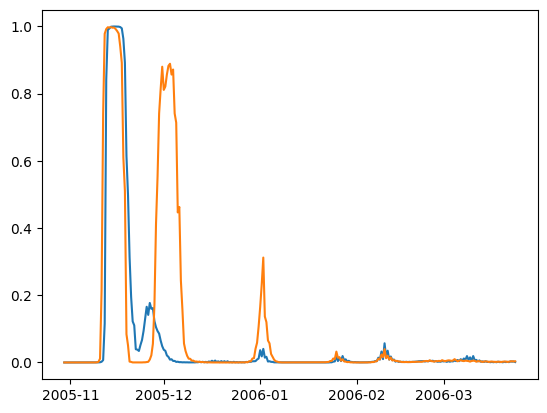

In [26]:
# To plot certainty curve giving the breeding date

import matplotlib.pyplot as plt

ind_index = 27
loc_vect = np.array(out)
n_detect_vect = np.array(out3)

year = data.iloc[ind_index]["year"]
vector_loc = loc_vect[ind_index]
vector_detect = n_detect_vect[ind_index]
    
vector_compiled = [[0] for x in range(60,351)]
for i in range(60,351):  #before 397
    value_temp = vector_loc[i-60:i+150]
    value_temp_detect = vector_detect[i-60:i+150]
    vector_compiled[i-60]= list(zip(value_temp, value_temp_detect)) 

temp_cert_date_M = model_date_males.predict(np.array(vector_compiled))
temp_cert_date_F = model_date_females.predict(np.array(vector_compiled))

M=[]
F=[]

for i in range(len(temp_cert_date_M)):
    M.append(temp_cert_date_M[i][0])
    F.append(temp_cert_date_F[i][0])

start_date = datetime.datetime(year=int(year-1), month=10, day=30)
end_date = start_date + timedelta(days=145)
dRange = pd.date_range(start=start_date, end=end_date, freq="12H")

plt.plot(dRange, M)
plt.plot(dRange, F)

In [27]:
## Example of activation map visualization for successful vs failing breeding

import tensorflow as tf
import matplotlib.pyplot as plt
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.scores import CategoricalScore
replace2linear = ReplaceToLinear()

gradcam_S_F = Gradcam(model_S_F,
                  model_modifier=replace2linear,
                  clone=True)

index_rfid_year = 27
vector = final_value[index_rfid_year]
val = tf.expand_dims(np.array(vector).astype(np.float32), axis=0)
score = CategoricalScore([1])
gradcam_map_S_F = gradcam_S_F(score, val, penultimate_layer=-1)

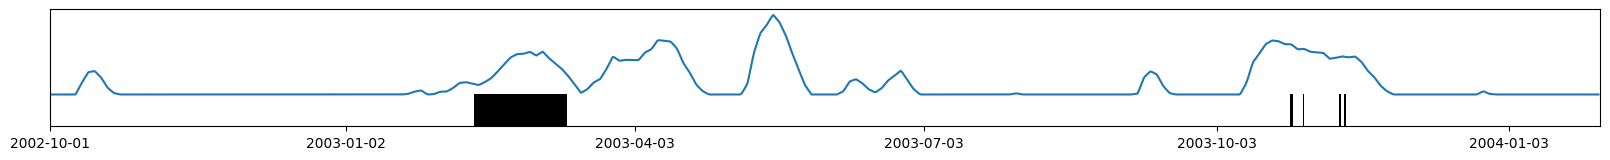

In [31]:
x=[]
for i in(vector):
    x.append(i[0])
start_date = datetime.datetime(year=int(data.iloc[index_rfid_year]["year"]), month=10, day=1)
end_date = start_date + timedelta(days=487)
dRange = pd.date_range(start=start_date, end=end_date, freq="12H")

fig, ax = plt.subplots(figsize = (20,10))
ax.imshow([x]*20,cmap='binary',interpolation='none', extent=[0, 975, -20, 0])
xlab = [0,186,368,550,734,918] 
ax.set_xticks(xlab)
ax.set_xticklabels([dRange.date[i] for i in xlab])
ax.axes.get_yaxis().set_visible(False)
ax.plot(gradcam_map_S_F[0]*50)
fig.savefig('cyclemap_success.png', dpi = 300)

In [32]:
gradcam_NB_B = Gradcam(model_NB_B,
                  model_modifier=replace2linear,
                  clone=True)

index_rfid_year = 10
vector = final_value[index_rfid_year]

val = tf.expand_dims(np.array(vector).astype(np.float32), axis=0)
score = CategoricalScore([1])
gradcam_map_NB_B = gradcam_NB_B(score, val, penultimate_layer=-1)

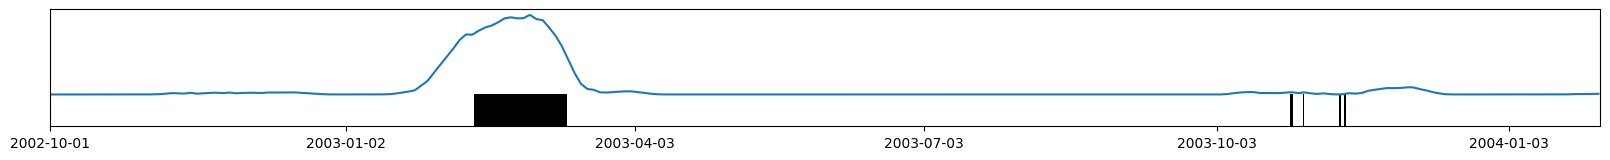

In [33]:
x=[]
for i in(vector):
    x.append(i[0])
start_date = datetime.datetime(year=int(data.iloc[index_rfid_year]["year"]), month=10, day=1)
end_date = start_date + timedelta(days=487)
dRange = pd.date_range(start=start_date, end=end_date, freq="12H")

fig, ax = plt.subplots(figsize = (20,10))
ax.imshow([x]*20,cmap='binary',interpolation='none', extent=[0, 975, -20, 0])
xlab = [0,186,368,550,734,918] 
ax.set_xticks(xlab)
ax.set_xticklabels([dRange.date[i] for i in xlab])
ax.axes.get_yaxis().set_visible(False)
ax.plot(gradcam_map_NB_B[0]*50)
fig.savefig('cyclemap_fail.png', dpi = 300)